#Name: Nayeemul Hasan
#ID: 22101622
#CSE425 Section 2


#AUTO ENCODER

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.utils import resample
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Setting up...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
true_labels_full = train_dataset.targets.numpy()

Setting up...


In [30]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 10))

        self.decoder = nn.Sequential(nn.Linear(10, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 28 * 28),
                                     nn.Tanh())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded

print("Training the simple autoencoder for 20 epochs...")
model_ae = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=1e-3)
for epoch in range(20):
    for data, _ in train_loader:
        images = data.to(device)
        outputs = model_ae(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    print(f"Epoch {epoch+1}/20 complete.")

Training the simple autoencoder for 20 epochs...
Epoch 1/20 complete.
Epoch 2/20 complete.
Epoch 3/20 complete.
Epoch 4/20 complete.
Epoch 5/20 complete.
Epoch 6/20 complete.
Epoch 7/20 complete.
Epoch 8/20 complete.
Epoch 9/20 complete.
Epoch 10/20 complete.
Epoch 11/20 complete.
Epoch 12/20 complete.
Epoch 13/20 complete.
Epoch 14/20 complete.
Epoch 15/20 complete.
Epoch 16/20 complete.
Epoch 17/20 complete.
Epoch 18/20 complete.
Epoch 19/20 complete.
Epoch 20/20 complete.


In [31]:
print("\nExtracting features and running K-Means...")
model_ae.eval()
latent_vectors = []
with torch.no_grad():
    for data, _ in train_loader:
        images = data.to(device)
        encoded_data = model_ae.encoder(images.view(images.size(0), -1))
        latent_vectors.append(encoded_data.cpu())
latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
predicted_labels = kmeans.fit_predict(latent_vectors)


Extracting features and running K-Means...


In [32]:
print("Calculating final scores...")
ari = adjusted_rand_score(true_labels_full, predicted_labels)
nmi = normalized_mutual_info_score(true_labels_full, predicted_labels)
sample_vectors, sample_labels = resample(latent_vectors, predicted_labels, n_samples=5000, random_state=42)
silhouette = silhouette_score(sample_vectors, sample_labels)
print("\n--- Deterministic Baseline Results ---")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Silhouette Score (on a sample of 5000): {silhouette:.4f}\n")

Calculating final scores...

--- Deterministic Baseline Results ---
Adjusted Rand Index (ARI): -0.0000
Normalized Mutual Information (NMI): 0.0002
Silhouette Score (on a sample of 5000): 0.1827



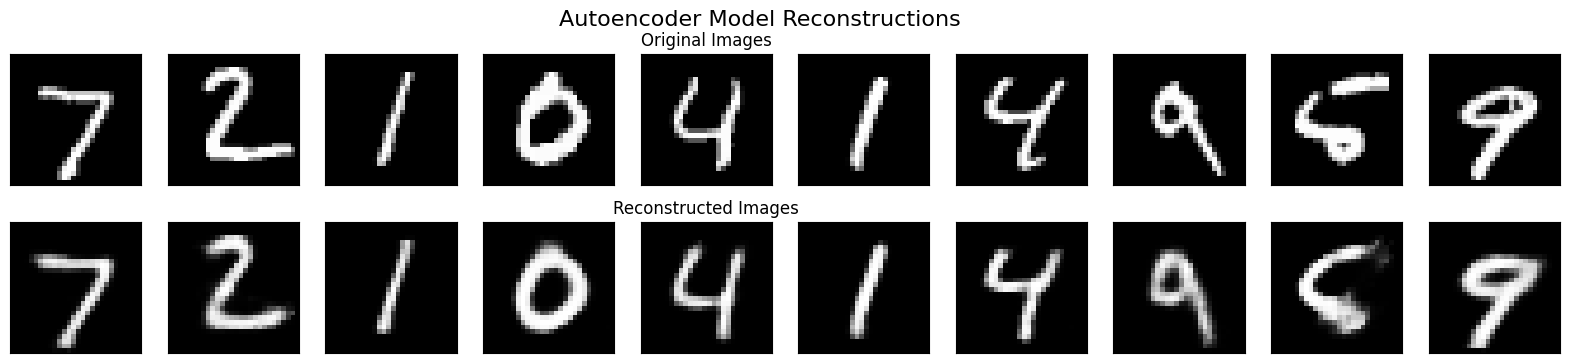

In [33]:
model_ae.eval()
images, _ = next(iter(test_loader))
images = images.to(device)
with torch.no_grad(): reconstructions = model_ae(images)
images, reconstructions = images.cpu(), reconstructions.cpu()
plt.figure(figsize=(20, 4));
for i in range(10):
    ax = plt.subplot(2, 10, i + 1); plt.imshow(images[i].squeeze() * 0.5 + 0.5, cmap='gray'); ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    if i == 4: ax.set_title("Original Images")
    ax = plt.subplot(2, 10, i + 1 + 10); plt.imshow(reconstructions[i].squeeze() * 0.5 + 0.5, cmap='gray'); ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    if i == 4: ax.set_title("Reconstructed Images")
plt.suptitle("Autoencoder Model Reconstructions", fontsize=16)
plt.show()

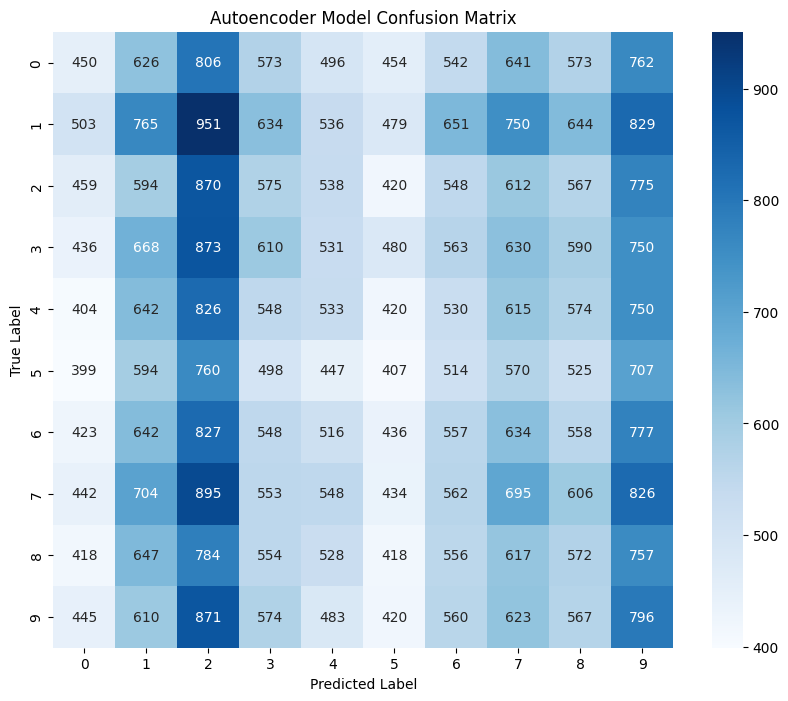

In [34]:
contingency = contingency_matrix(true_labels_full, predicted_labels)
row_ind, col_ind = linear_sum_assignment(-contingency)
remapped_labels = np.zeros_like(predicted_labels)
for i in range(10): remapped_labels[predicted_labels == col_ind[i]] = row_ind[i]
cm = confusion_matrix(true_labels_full, remapped_labels)
plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');
plt.title('Autoencoder Model Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label');
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


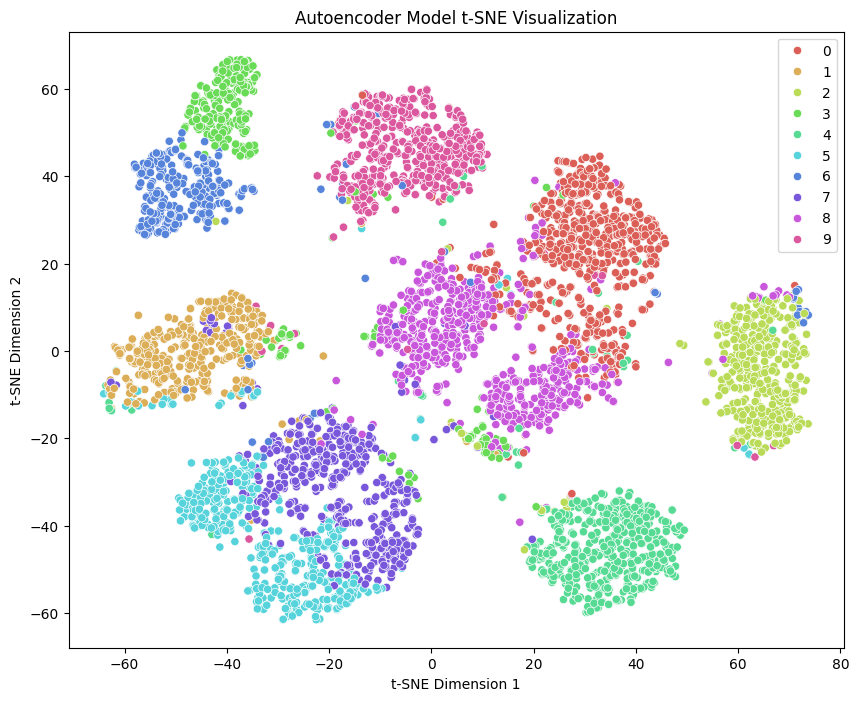

In [35]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(sample_vectors)
plt.figure(figsize=(10, 8)); sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=sample_labels, palette=sns.color_palette("hls", 10), legend="full");
plt.title('Autoencoder Model t-SNE Visualization'); plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2');
plt.show()

#Variational Autoencoder

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
BETA = 4
LATENT_DIM = 10


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("MNIST dataset loaded successfully.")

Using device: cuda
MNIST dataset loaded successfully.


In [37]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mean = nn.Linear(256, LATENT_DIM)
        self.fc_log_var = nn.Linear(256, LATENT_DIM)

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        mu, log_var = self.fc_mean(h), self.fc_log_var(h)

        z = self.reparameterize(mu, log_var)

        reconstruction = self.decoder(z)
        reconstruction = reconstruction.view(x.size(0), 1, 28, 28)

        return reconstruction, mu, log_var

In [38]:
vae_model = VAE().to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)

def vae_loss_function(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + BETA * kl_div

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for data, _ in train_loader:
        images = data.to(device)
        reconstructions, mu, log_var = vae_model(images)
        loss = vae_loss_function(reconstructions, images, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_epoch_loss:.4f}')

print("VAE training finished.")

Epoch [1/20], Loss: 182.6913
Epoch [2/20], Loss: 138.5052
Epoch [3/20], Loss: 131.3070
Epoch [4/20], Loss: 127.9711
Epoch [5/20], Loss: 125.7020
Epoch [6/20], Loss: 124.1673
Epoch [7/20], Loss: 122.7449
Epoch [8/20], Loss: 121.7533
Epoch [9/20], Loss: 120.8820
Epoch [10/20], Loss: 120.1389
Epoch [11/20], Loss: 119.5069
Epoch [12/20], Loss: 118.9968
Epoch [13/20], Loss: 118.4715
Epoch [14/20], Loss: 117.9431
Epoch [15/20], Loss: 117.6450
Epoch [16/20], Loss: 117.4165
Epoch [17/20], Loss: 117.0439
Epoch [18/20], Loss: 116.7122
Epoch [19/20], Loss: 116.5117
Epoch [20/20], Loss: 116.2885
VAE training finished.


In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

vae_model.eval()

latent_vectors = []
true_labels = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        _, mu, _ = vae_model(data)
        latent_vectors.append(mu.cpu())
        true_labels.append(labels)

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
true_labels = torch.cat(true_labels, dim=0).numpy()

print("Feature vectors extracted.")

kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
predicted_labels = kmeans.fit_predict(latent_vectors)

print("K-Means clustering complete.")

ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)
from sklearn.utils import resample
sample_vectors, sample_labels = resample(latent_vectors, predicted_labels, n_samples=5000, random_state=42)
silhouette = silhouette_score(sample_vectors, sample_labels)

print("\n--- Final Evaluation Metrics ---")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Silhouette Score (on a sample of 5000): {silhouette:.4f}")

Feature vectors extracted.
K-Means clustering complete.

--- Final Evaluation Metrics ---
Adjusted Rand Index (ARI): 0.4378
Normalized Mutual Information (NMI): 0.5356
Silhouette Score (on a sample of 5000): 0.1687


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


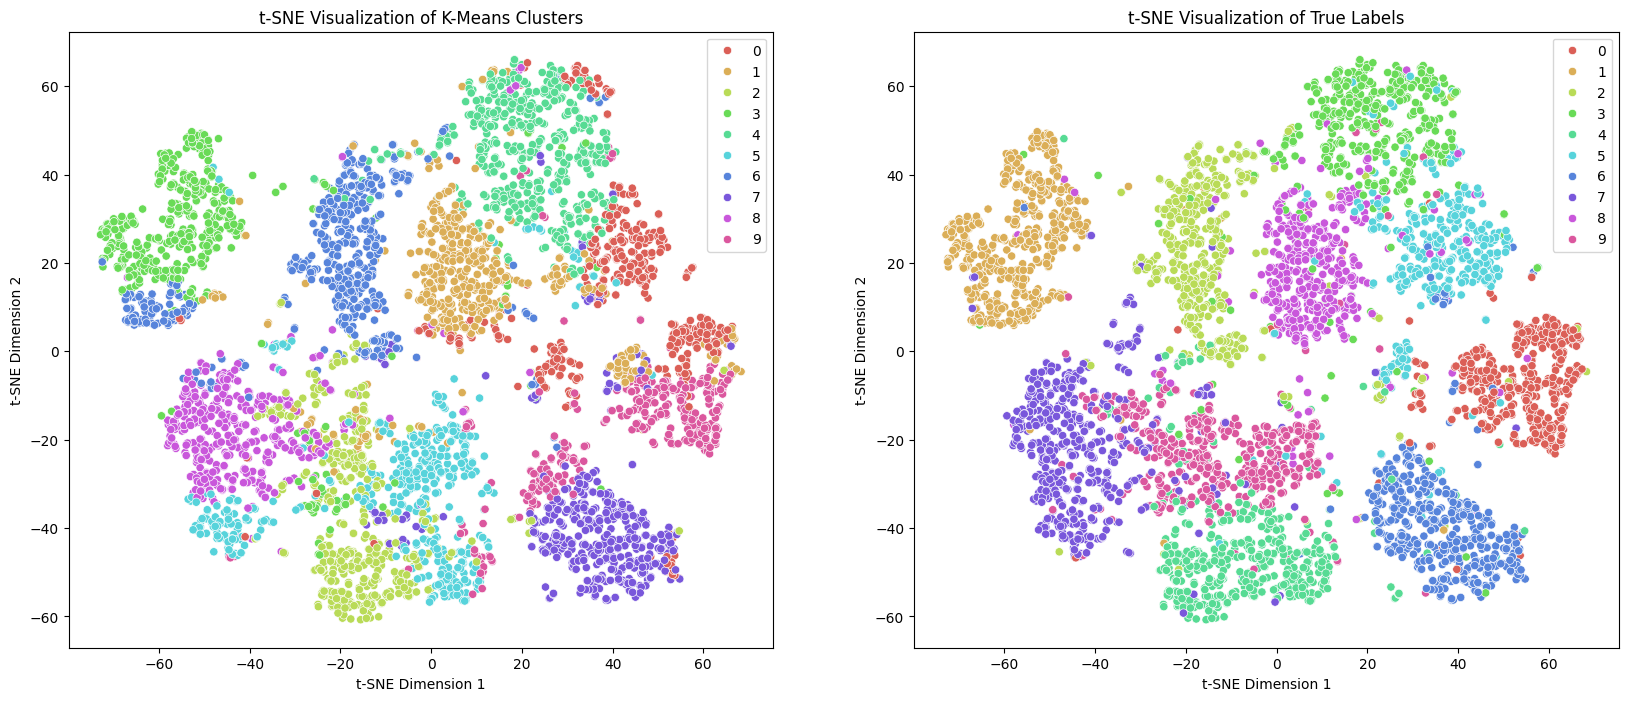

In [40]:
from sklearn.manifold import TSNE
import seaborn as sns

sample_vectors_for_viz = sample_vectors
true_labels_sample = resample(true_labels, n_samples=5000, random_state=42)
predicted_labels_sample = sample_labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(sample_vectors_for_viz)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=predicted_labels_sample,
    palette=sns.color_palette("hls", 10),
    legend="full"
)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=true_labels_sample,
    palette=sns.color_palette("hls", 10),
    legend="full"
)
plt.title('t-SNE Visualization of True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.show()

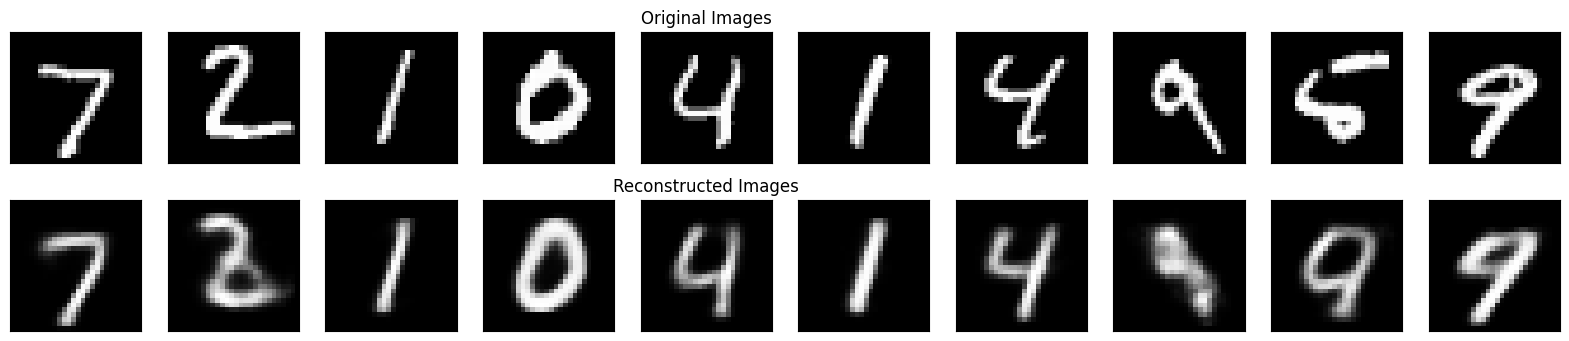

In [41]:
vae_model.eval()
images, _ = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    reconstructions, _, _ = vae_model(images)

images = images.cpu()
reconstructions = reconstructions.cpu()

plt.figure(figsize=(20, 4))
for i in range(10):

    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].squeeze() * 0.5 + 0.5, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 4:
        ax.set_title("Original Images")

    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructions[i].squeeze() * 0.5 + 0.5, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 4:
        ax.set_title("Reconstructed Images")
plt.show()

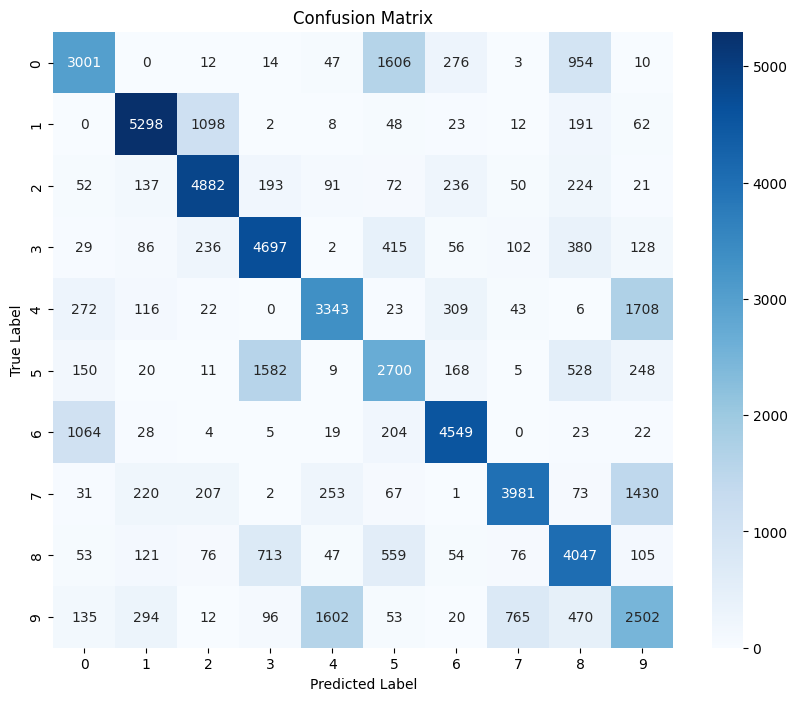

In [42]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix

contingency = contingency_matrix(true_labels, predicted_labels)
row_ind, col_ind = linear_sum_assignment(-contingency)

remapped_labels = np.zeros_like(predicted_labels)
for i in range(10):

    mask = (predicted_labels == col_ind[i])
    remapped_labels[mask] = row_ind[i]

cm = confusion_matrix(true_labels, remapped_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

/tmp/ipython-input-2519972502.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uncertainty_by_class.index, y=uncertainty_by_class.values, palette="viridis")


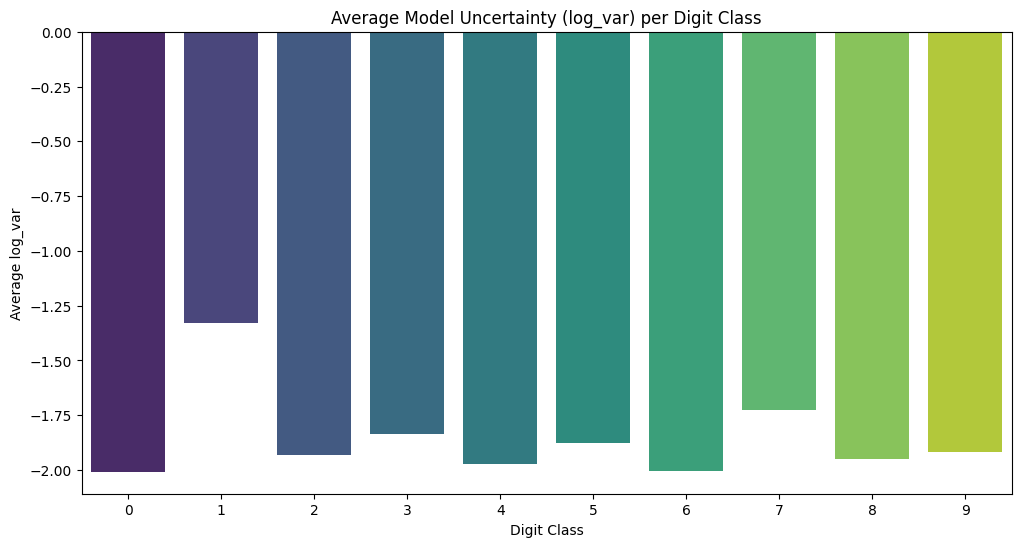

In [43]:
import pandas as pd
import seaborn as sns

vae_model.eval()

all_log_vars = []
all_labels = []
with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        _, _, log_var = vae_model(data)
        all_log_vars.append(log_var.cpu())
        all_labels.append(labels.cpu())

all_log_vars = torch.cat(all_log_vars, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

avg_log_var_per_sample = np.mean(all_log_vars, axis=1)
df = pd.DataFrame({'label': all_labels, 'avg_log_var': avg_log_var_per_sample})
uncertainty_by_class = df.groupby('label')['avg_log_var'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=uncertainty_by_class.index, y=uncertainty_by_class.values, palette="viridis")
plt.title('Average Model Uncertainty (log_var) per Digit Class')
plt.xlabel('Digit Class')
plt.ylabel('Average log_var')
plt.show()

#Convolutional Variational Autoencoder

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
BETA = 4
LATENT_DIM = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("MNIST dataset loaded successfully.")

Using device: cuda
MNIST dataset loaded successfully.


In [45]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mean = nn.Linear(128 * 4 * 4, LATENT_DIM)
        self.fc_log_var = nn.Linear(128 * 4 * 4, LATENT_DIM)

        self.decoder_fc = nn.Linear(LATENT_DIM, 128 * 4 * 4)
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_mean(h), self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)

        recon_flat = self.decoder_fc(z)
        recon = self.decoder(recon_flat.view(-1, 128, 4, 4))

        return recon, mu, log_var

In [46]:
vae_model = ConvVAE().to(device)
optimizer = optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)

def vae_loss_function(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return recon_loss + BETA * kl_div

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for data, _ in train_loader:
        images = data.to(device)
        reconstructions, mu, log_var = vae_model(images)
        loss = vae_loss_function(reconstructions, images, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_epoch_loss:.4f}')

print("VAE training finished.")

Epoch [1/20], Loss: 183.3483
Epoch [2/20], Loss: 126.6606
Epoch [3/20], Loss: 122.1937
Epoch [4/20], Loss: 119.9583
Epoch [5/20], Loss: 118.4434
Epoch [6/20], Loss: 117.1601
Epoch [7/20], Loss: 116.3323
Epoch [8/20], Loss: 115.4081
Epoch [9/20], Loss: 114.8313
Epoch [10/20], Loss: 114.2767
Epoch [11/20], Loss: 113.8713
Epoch [12/20], Loss: 113.3329
Epoch [13/20], Loss: 112.9417
Epoch [14/20], Loss: 112.5655
Epoch [15/20], Loss: 112.2831
Epoch [16/20], Loss: 112.0285
Epoch [17/20], Loss: 111.7018
Epoch [18/20], Loss: 111.4343
Epoch [19/20], Loss: 111.2143
Epoch [20/20], Loss: 111.1338
VAE training finished.


In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

vae_model.eval()

latent_vectors = []
true_labels = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        _, mu, _ = vae_model(data)
        latent_vectors.append(mu.cpu())
        true_labels.append(labels)

latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
true_labels = torch.cat(true_labels, dim=0).numpy()

print("Feature vectors extracted.")

kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
predicted_labels = kmeans.fit_predict(latent_vectors)

print("K-Means clustering complete.")

ari = adjusted_rand_score(true_labels, predicted_labels)
nmi = normalized_mutual_info_score(true_labels, predicted_labels)

from sklearn.utils import resample
sample_vectors, sample_labels = resample(latent_vectors, predicted_labels, n_samples=5000, random_state=42)
silhouette = silhouette_score(sample_vectors, sample_labels)

print("\n--- Final Evaluation Metrics ---")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Silhouette Score (on a sample of 5000): {silhouette:.4f}")

Feature vectors extracted.
K-Means clustering complete.

--- Final Evaluation Metrics ---
Adjusted Rand Index (ARI): 0.5572
Normalized Mutual Information (NMI): 0.6381
Silhouette Score (on a sample of 5000): 0.1200


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


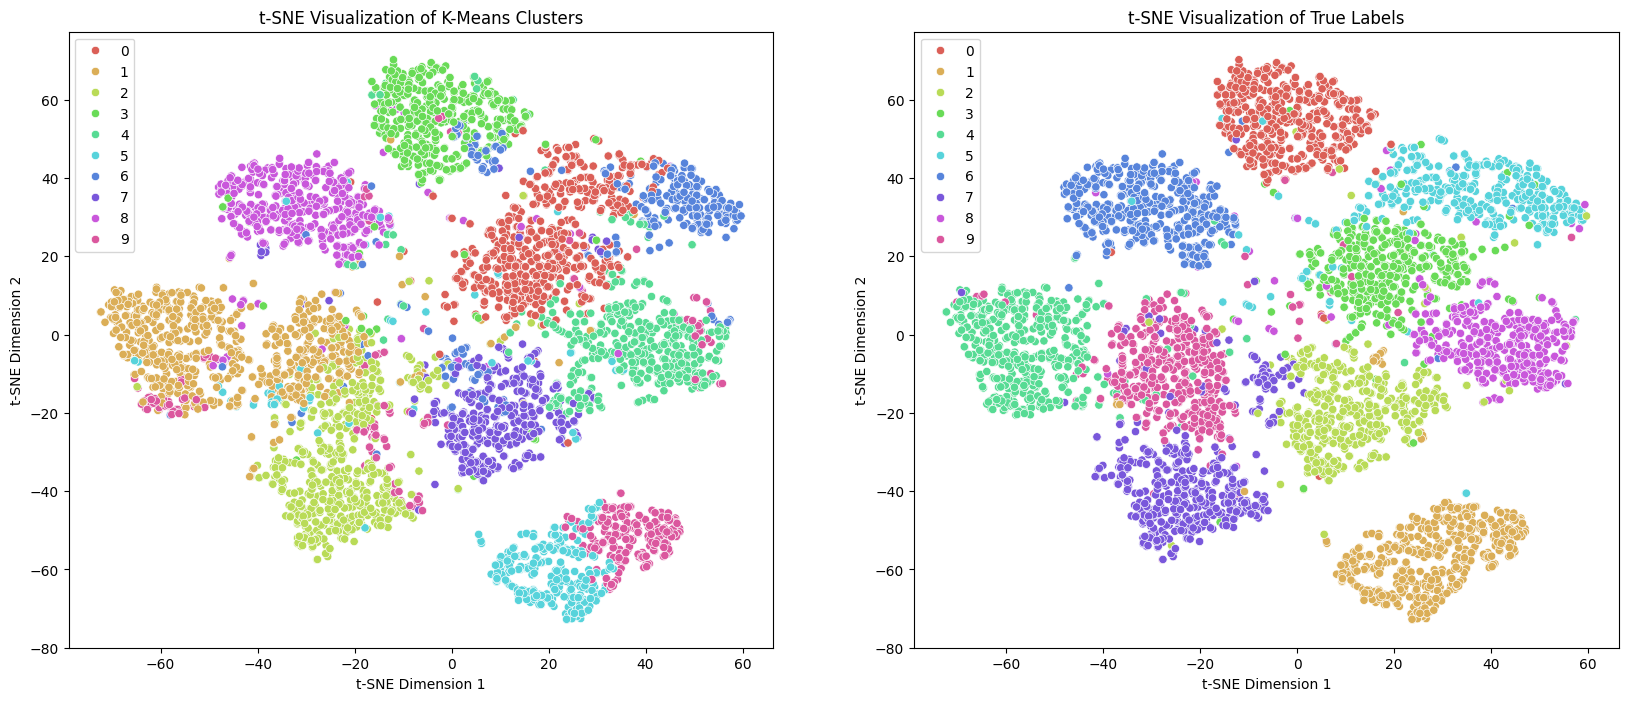

In [48]:
from sklearn.manifold import TSNE
import seaborn as sns

sample_vectors_for_viz = sample_vectors
true_labels_sample = resample(true_labels, n_samples=5000, random_state=42)
predicted_labels_sample = sample_labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(sample_vectors_for_viz)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=predicted_labels_sample,
    palette=sns.color_palette("hls", 10),
    legend="full"
)
plt.title('t-SNE Visualization of K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.subplot(1, 2, 2)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=true_labels_sample,
    palette=sns.color_palette("hls", 10),
    legend="full"
)
plt.title('t-SNE Visualization of True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.show()

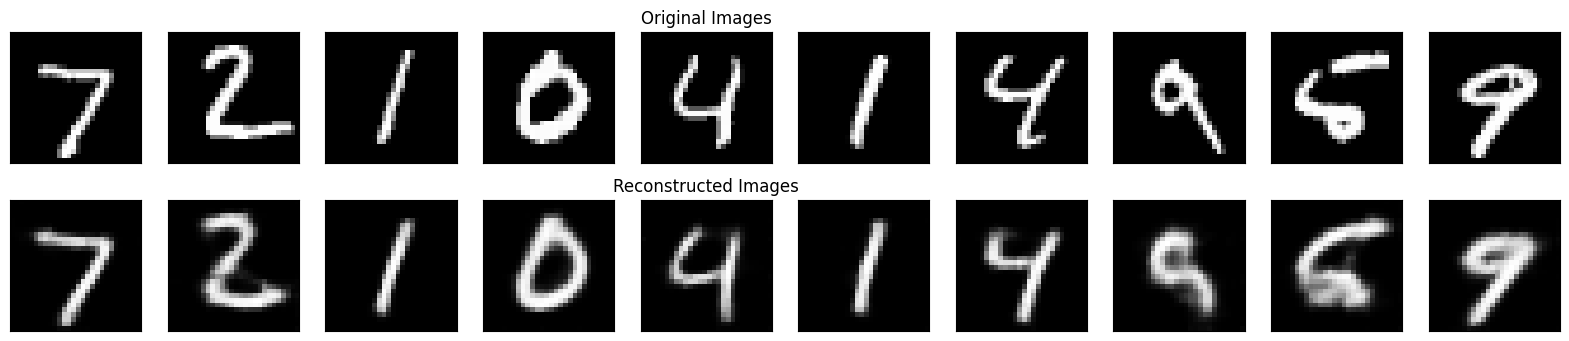

In [49]:
vae_model.eval()

images, _ = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    reconstructions, _, _ = vae_model(images)

images = images.cpu()
reconstructions = reconstructions.cpu()

plt.figure(figsize=(20, 4))
for i in range(10):

    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].squeeze() * 0.5 + 0.5, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 4:
        ax.set_title("Original Images")

    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(reconstructions[i].squeeze() * 0.5 + 0.5, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 4:
        ax.set_title("Reconstructed Images")
plt.show()

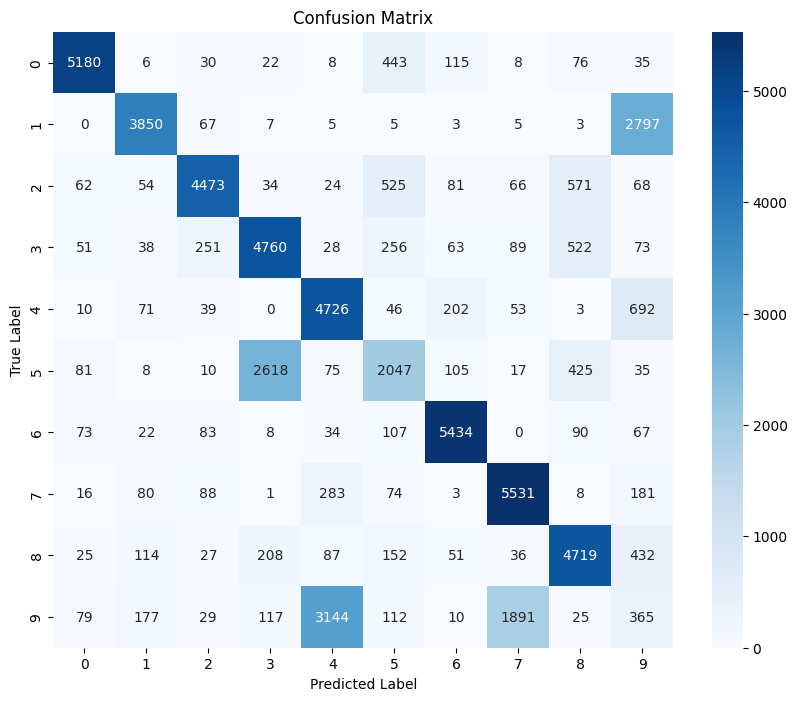

In [50]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix

contingency = contingency_matrix(true_labels, predicted_labels)
row_ind, col_ind = linear_sum_assignment(-contingency)


remapped_labels = np.zeros_like(predicted_labels)
for i in range(10):
    mask = (predicted_labels == col_ind[i])
    remapped_labels[mask] = row_ind[i]

cm = confusion_matrix(true_labels, remapped_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

/tmp/ipython-input-2383012617.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=uncertainty_by_class.index, y=uncertainty_by_class.values, palette="viridis")


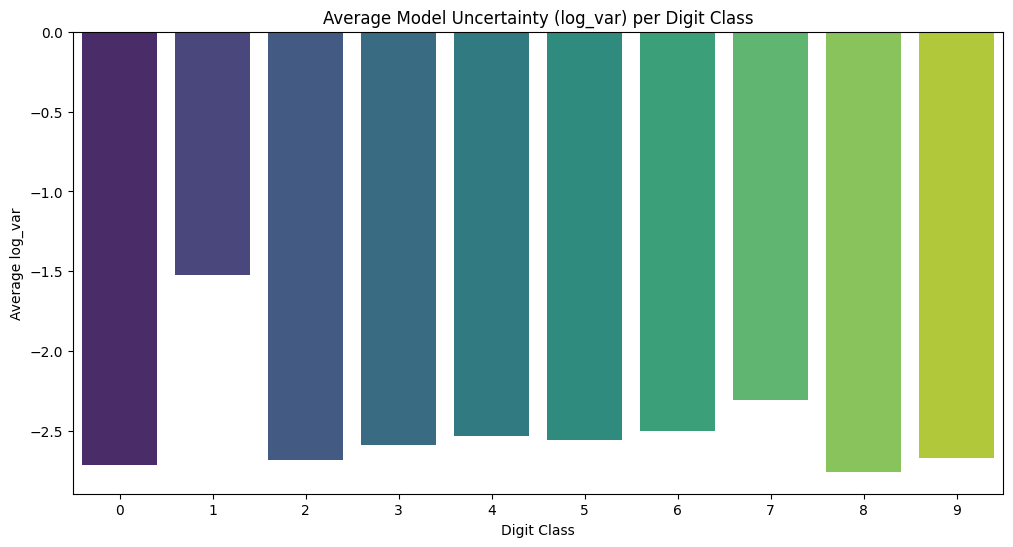

In [51]:
import pandas as pd
import seaborn as sns

vae_model.eval()

all_log_vars = []
all_labels = []
with torch.no_grad():
    for data, labels in train_loader:
        data = data.to(device)
        _, _, log_var = vae_model(data)
        all_log_vars.append(log_var.cpu())
        all_labels.append(labels.cpu())
all_log_vars = torch.cat(all_log_vars, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

avg_log_var_per_sample = np.mean(all_log_vars, axis=1)
df = pd.DataFrame({'label': all_labels, 'avg_log_var': avg_log_var_per_sample})
uncertainty_by_class = df.groupby('label')['avg_log_var'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=uncertainty_by_class.index, y=uncertainty_by_class.values, palette="viridis")
plt.title('Average Model Uncertainty (log_var) per Digit Class')
plt.xlabel('Digit Class')
plt.ylabel('Average log_var')
plt.show()

#Performance Comparison

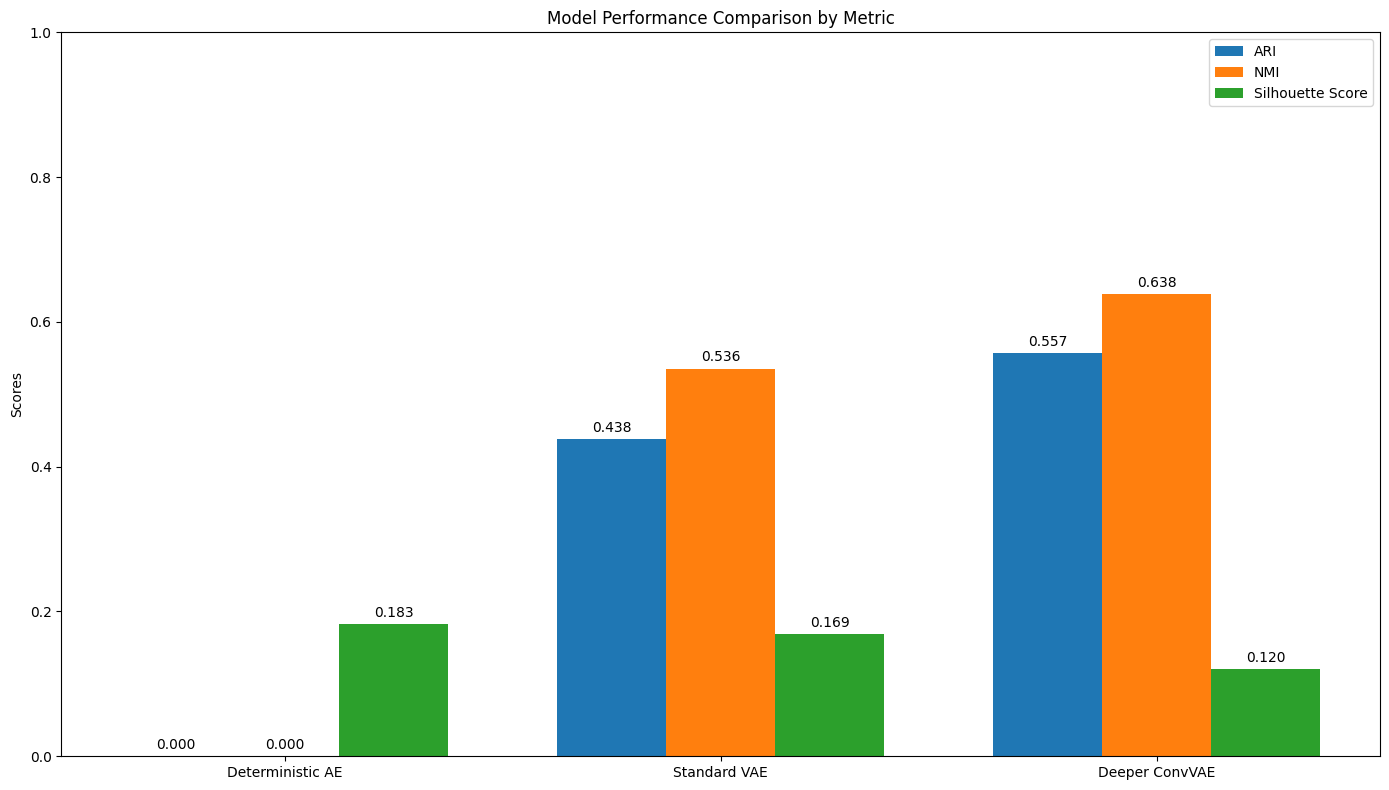

In [53]:
import numpy as np
import matplotlib.pyplot as plt


results = {
    'Deterministic AE': {
        'ARI': -0.0000,
        'NMI': 0.0002,
        'Silhouette': 0.1827
    },
    'Standard VAE': {
        'ARI': 0.4378,
        'NMI': 0.5356,
        'Silhouette': 0.1687
    },
    'Deeper ConvVAE': {
        'ARI': 0.5572,
        'NMI': 0.6381,
        'Silhouette': 0.1200
    }
}

labels = list(results.keys())
ari_scores = [res['ARI'] for res in results.values()]
nmi_scores = [res['NMI'] for res in results.values()]
silhouette_scores = [res['Silhouette'] for res in results.values()]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width, ari_scores, width, label='ARI')
rects2 = ax.bar(x, nmi_scores, width, label='NMI')
rects3 = ax.bar(x + width, silhouette_scores, width, label='Silhouette Score')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison by Metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')
ax.bar_label(rects3, padding=3, fmt='%.3f')
ax.set_ylim(0, 1.0)
fig.tight_layout()
plt.show()